# 02 - Exploratory Data Analysis

## Objetivo
- Explorar distribuciones y relaciones clave del dataset procesado.
- Identificar patrones por distrito/subdistrito y posibles sesgos.
- Revisar densidades espaciales y missingness por zona.

## Flujo general
- Cargar `artifacts/processed_rent.*`.
- Graficar distribuciones de price, price_m2, surface_m2.
- Comparar medianas por zona y visualizar mapa de precios.
- Resumir missingness y correlaciones numericas.

## Inputs
- `artifacts/processed_rent.csv.gz`

## Outputs
- Figuras EDA (histograma, barras por zona, mapas y correlaciones).


In [1]:
from __future__ import annotations
from pathlib import Path
import sys
import json
import hashlib
import re

import numpy as np
import pandas as pd

# --- Base setup y reproducibilidad ---
SEED = 42
np.random.seed(SEED)


def get_repo_root() -> Path:
    """Return repo root by walking parents and checking .git/pyproject.toml."""
    current = Path.cwd().resolve()
    for parent in [current] + list(current.parents):
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return current

ROOT = get_repo_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import plot_maps, spatial_group

# --- Cargar dataset procesado ---
processed_path = ROOT / "artifacts" / "processed_rent.parquet"
if processed_path.exists():
    rent_df = pd.read_parquet(processed_path)
else:
    rent_df = pd.read_csv(ROOT / "artifacts" / "processed_rent.csv.gz")

rent_df.head()


,web_id,url,title,type,price,deposit,private_owner,professional_name,floor_built,floor_area,...,location,district,subdistrict,postalcode,last_update,lat,lng,surface_m2,price_m2,distance_center_km
0,99440018,https://www.idealista.com/en/inmueble/99440018/,Studio flat for rent in luis cabrera,Studio,650.0,1.0,False,Madrid en Propiedad,30,NaN,...,"luis cabrera, Subdistrict Prosperidad, Distric...",Chamartín,Prosperidad,28002.0,2025-11-07 00:00:00,40.444750,-3.671574,NaN,NaN,4.135075
1,99440827,https://www.idealista.com/en/inmueble/99440827/,Flat / apartment for rent in calle de Pastora ...,Flat,1750.0,NaN,False,PUBLICASA MADRID,148,NaN,...,"Calle de Pastora Imperio, Subdistrict Castilla...",Chamartín,Castilla,28036.0,2025-11-07 00:00:00,40.481725,-3.674384,NaN,NaN,7.636373
2,97689853,https://www.idealista.com/en/inmueble/97689853/,Flat / apartment for rent in calle de Gabriel ...,Flat,1490.0,NaN,False,roomless,65,55.0,...,"Calle de Gabriel Lobo, 20, Subdistrict El Viso...",Chamartín,El Viso,28002.0,2025-11-05 00:00:00,40.443449,-3.679917,55.0,27.090909,3.587088
3,97689852,https://www.idealista.com/en/inmueble/97689852/,Flat / apartment for rent in calle de Gabriel ...,Flat,900.0,NaN,False,roomless,50,40.0,...,"Calle de Gabriel Lobo, 20, Subdistrict El Viso...",Chamartín,El Viso,28002.0,2025-11-05 00:00:00,40.443449,-3.679917,40.0,22.500000,3.587088
4,99399876,https://www.idealista.com/en/inmueble/99399876/,Flat / apartment for rent in El Viso,Flat,950.0,NaN,False,Spotahome,28,24.0,...,", Subdistrict El Viso, District Chamartín, Mad...",Chamartín,El Viso,NaN,2025-11-06 00:00:00,40.449021,-3.686681,24.0,39.583333,3.864720


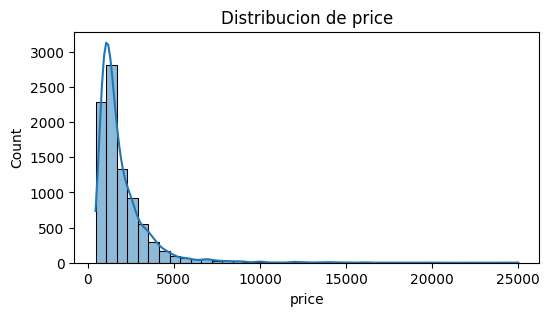

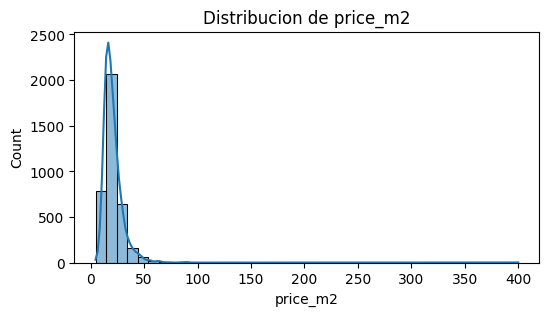

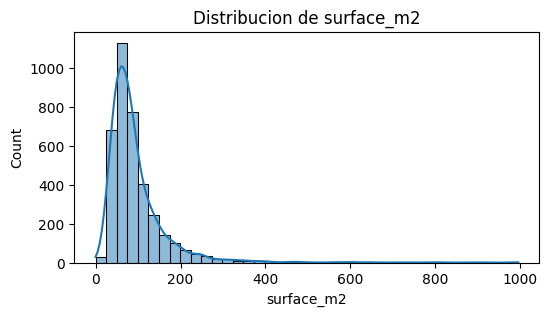

In [3]:
# Distribuciones principales
for col in ["price", "price_m2", "surface_m2"]:
    if col in rent_df.columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(rent_df[col].dropna(), bins=40, kde=True)
        plt.title(f"Distribucion de {col}")
        plt.show()


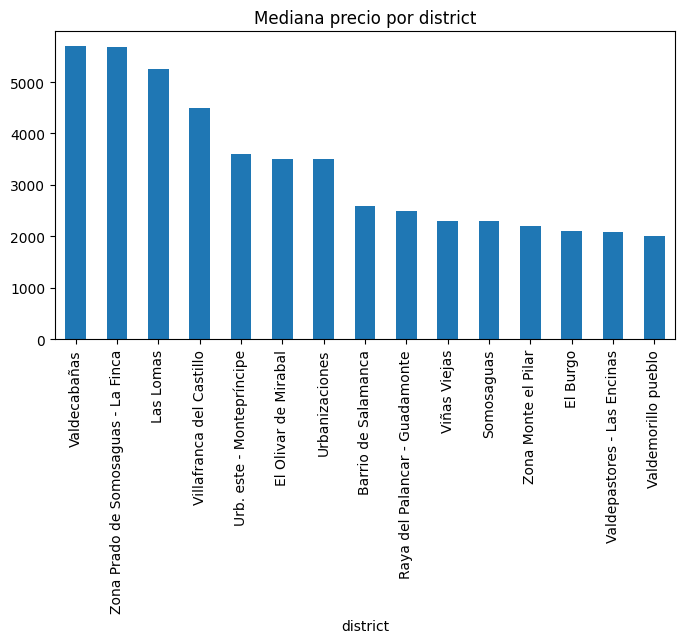

In [4]:
# Comparativas por distrito o zona
cat_cols = [
    c for c in rent_df.columns
    if any(k in c.lower() for k in ["distrito", "barrio", "district", "subdistrict"])
]
if cat_cols and "price" in rent_df.columns:
    group_col = cat_cols[0]
    summary = rent_df.groupby(group_col)["price"].median().sort_values(ascending=False).head(15)
    summary.plot(kind="bar", figsize=(8, 4), title=f"Mediana precio por {group_col}")
    plt.show()


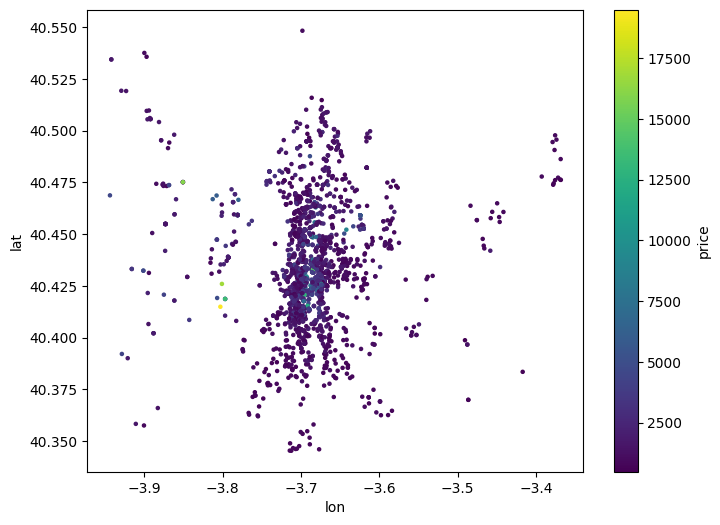

In [5]:
# Mapas base de densidad/precio
lat_col = next((c for c in rent_df.columns if "lat" in c.lower()), None)
lon_col = next((c for c in rent_df.columns if "lon" in c.lower() or "lng" in c.lower()), None)

if lat_col and lon_col:
    # Agrupar por geohash para densidad (para resumen rapido)
    rent_df["geohash_6"] = spatial_group(rent_df, lat_col, lon_col, precision=6)
    geo_summary = rent_df.groupby("geohash_6").agg(
        count=("geohash_6", "size"),
        price_median=("price", "median"),
    ).reset_index()
    # Mapa con muestra de puntos
    plot_maps(rent_df.sample(min(2000, len(rent_df))), lat_col, lon_col, "price")


In [6]:
# Missingness por zona
zone_cols = [
    c for c in rent_df.columns
    if any(k in c.lower() for k in ["distrito", "barrio", "district", "subdistrict"])
]
if zone_cols:
    zone_col = zone_cols[0]
    # Promedio de nulos por zona (mean de columnas)
    missing_summary = rent_df.isna().groupby(rent_df[zone_col]).mean().mean(axis=1)
    missing_summary.sort_values(ascending=False).head(10)


### Visualizaciones
- Mapa de correlaciones para detectar colinealidad.
- Boxplots por zona (top 12) para detectar dispersion y outliers.


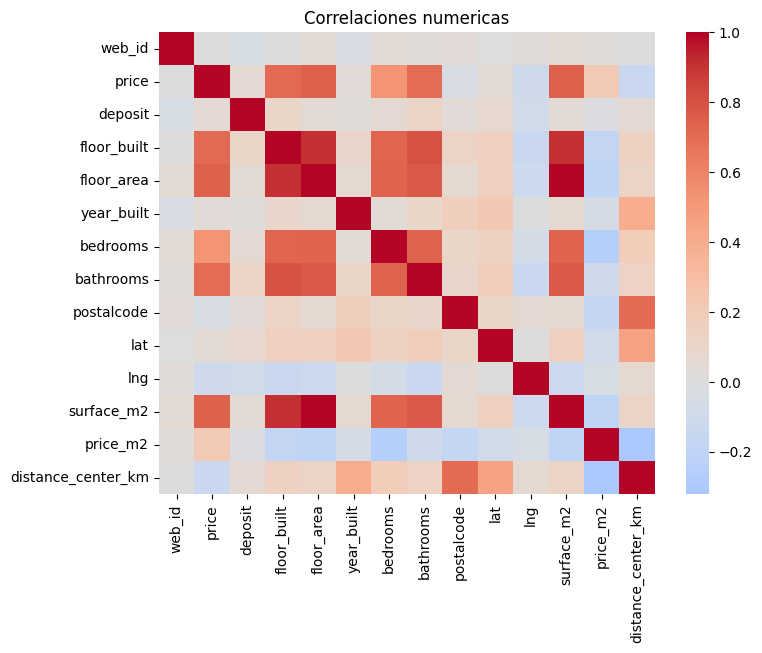

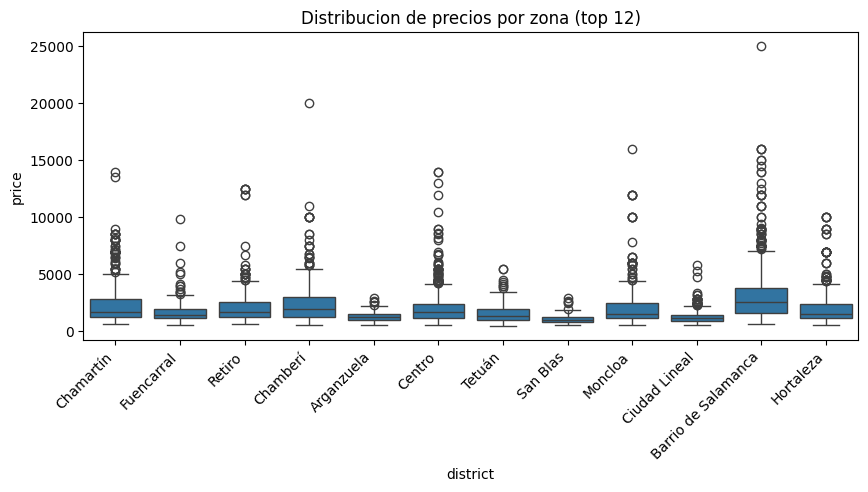

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlaciones numericas
numeric = rent_df.select_dtypes(include=["number"])
if not numeric.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric.corr(), cmap="coolwarm", center=0)
    plt.title("Correlaciones numericas")
    plt.show()

# Boxplots de precio en top zonas
if cat_cols and "price" in rent_df.columns:
    top_zones = rent_df[group_col].value_counts().head(12).index
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=rent_df[rent_df[group_col].isin(top_zones)], x=group_col, y="price")
    plt.xticks(rotation=45, ha="right")
    plt.title("Distribucion de precios por zona (top 12)")
    plt.show()
